# 线性回归

In [1]:
import numpy as np
import math 
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
import matplotlib.pylab as plt

## 1 数据准备

In [2]:
def shuffle_data(X, y, seed=None):
    "将数据集中的X和y打乱"
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]

In [3]:
def train_test_split(X, y, test_size=0.5, shuffle=True,seed=None):
    "将数据集根据test_size分成训练集和测试集，可以指定是否随机洗牌"
    if shuffle:
        X, y = shuffle_data(X, y, seed=seed)
    split_i = len(y) - int(len(y) // (1/test_size))
    X_train, X_test = X[ :split_i], X[split_i: ]
    y_train, y_test = y[ :split_i], y[split_i: ]
    return X_train, y_train, X_test, y_test

In [4]:
# 关键参数有n_samples（生成样本数），n_features（样本特征数），noise（样本随机噪音）和coef（是否返回回归系数
# X为样本特征，y为样本输出， coef为回归系数，共1000个样本，每个样本1个特征
# 使用make_regression函数使得X乱序，在绘制matplot的图像时会有问题(线图会展示出乱七八糟的)，所以对于X进行排序
X, y = make_regression(n_samples=200, n_features=1, noise=20)

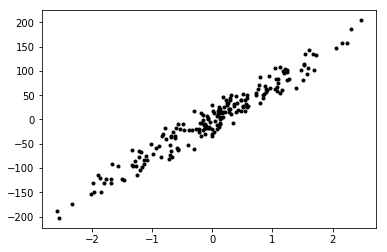

In [5]:
plt.plot(X, y, "k.")

In [6]:
X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.2) 

In [7]:
s=sorted([(X_test[i][0],y_test[i]) for i in range(len(X_test))],key=lambda j:j[0])

In [8]:
X_test=np.array([[j[0]] for j in s])
y_test=np.array([j[1] for j in s])

## 2 线性回归

In [9]:
class Regression(object):
    
    """
        基础线性回归模型，使用输入的X和y进行参数回归
        超参：
        n_iterations:int 训练的步数
        learning_rate:float 学习率
        内部函数:
        initialize_weights:初始化参数
        fit:开始训练
        predict:预测
        内部的数据:
        n_iterations
        learning_rate
        regularization:正则化参数
        regularization.grad:正则化的梯度函数
    """
    
    def __init__(self,n_iterations,learning_rate):
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.regularization = lambda x:0
        self.regularization.grad = lambda x:0
        
    # 为什么要这样初始化呢？
    def initialize_weights(self,n_features):
        "初始化系数，输入是feature的个数，输出是一个随机初始化好的参数矩阵,[-1/sqrt(N),1/sqrt(N)]"
        limit = 1/math.sqrt(n_features)
        self.w = np.random.uniform(-limit,limit,(n_features,))
    
    def fit(self,X,y):
        # 插入偏置列1到X中
        X = np.insert(X,0,1,axis=1)  # 给每一行的第0列增加一个1
        self.training_errors = []    # 保存每一次步长的训练Loss
        self.initialize_weights(n_features=X.shape[1])   # 初始化参数w
        
        # 进行梯度下降迭代
        for i in range(self.n_iterations):
            y_pred = X.dot(self.w)    # 进行预测
            # 计算Loss
            mse=np.mean(0.5*(y-y_pred)**2+self.regularization(self.w))
            self.training_errors.append(mse)#将Loss加入到training_errors的数组中
            #计算带有正则化项的梯度
            g_w=-(y-y_pred).T.dot(X)/len(X)+self.regularization.grad(self.w)
            #根据梯度下降的算法更新参数
            self.w-=self.learning_rate*g_w
            
    def predict(self,X):
        #通过输入X预测一个样本
        X=np.insert(X,0,1,axis=1)
        pred=X.dot(self.w)
        return pred

In [10]:
model=Regression(n_iterations=1000,learning_rate=0.01)

In [11]:
model.fit(X_train,y_train)

Text(0.5, 0, 'Steps')

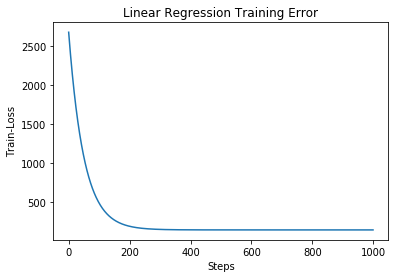

In [12]:
training =plt.plot(range(len(model.training_errors)),model.training_errors,label="Training Error")
plt.title("Linear Regression Training Error")
plt.ylabel("Train-Loss")
plt.xlabel("Steps")

In [13]:
model.w

array([ 0.23591073, 72.14025739])

## 3 评价模型

In [14]:
y_pred = model.predict(X_test)

In [15]:
mse = mean_squared_error(y_pred,y_test)

In [16]:
mse

234.72508859327644

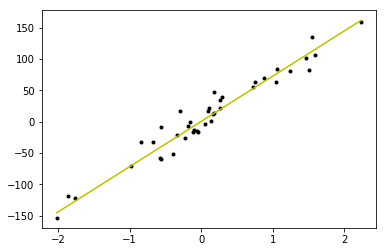

In [17]:
plt.plot(X_test,y_test,'k.')
plt.plot(X_test,y_pred,'Y')

## 4 最小二乘法线性回归

In [18]:
def lsm_function(X,y):
    G=np.mat(np.insert(X,0,1,axis=1))
    return np.squeeze(np.asarray((G.T.dot(G)).I.dot(G.T).dot(y)))

In [19]:
lsm_function(X_train,y_train)

array([ 0.23591796, 72.1435142 ])

In [20]:
class LinearRegression(Regression):
    """带有最小二乘法的线性回归
    参数:
    -------------
    n_iterations
    learning_rate
    gradient_descent:bool 
        决定是否使用梯度下降法，如果是True则使用梯度下降，False使用最小二乘
    """
    def __init__(self,n_iterations=500,learning_rate=0.1,gradient_descent=True):
        self.gradient_descent=gradient_descent
        self.regularization=lambda x:0
        self.regularization.grad=lambda x:0
        super(LinearRegression,self).__init__(n_iterations=n_iterations,learning_rate=learning_rate)
    
    def fit(self,X,y):
        if not self.gradient_descent:
            self.w=lsm_function(X,y)
        else:
            super(LinearRegression,self).fit(X,y)
    
    def predict(self,X):
        return super(LinearRegression,self).predict(X)

In [21]:
model=LinearRegression(n_iterations=1000,learning_rate=0.1,gradient_descent=False)

In [22]:
model.fit(X_train,y_train)

In [23]:
model.w

array([ 0.23591796, 72.1435142 ])

In [24]:
def test_and_draw(model):
    y_pred=model.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    print("方差:",mse)
    plt.plot(X_test,y_test,'k.')
    plt.plot(X_test,y_pred,'Y')

方差: 234.73672427161878


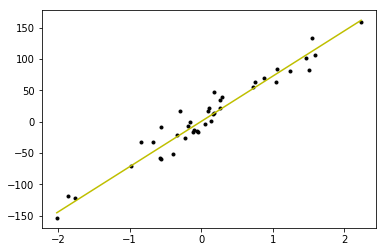

In [25]:
test_and_draw(model)

## 5 正则化回归
### 5.1 L1 正则化

In [26]:
class l1_regularization():
    """L1正则化类/函数
    参数:
    
    alpha--L1正则化系数
    """
    def __init__(self,alpha):
        self.alpha=alpha
    def __call__(self,w):
        return self.alpha*np.linalg.norm(w,ord=1)
    def grad(self,w):
        #w>0->w`=1;w<0->w`=0;w==0->w`=0
        return self.alpha*np.sign(w)

In [27]:
l1=l1_regularization(alpha=0.01)

In [28]:
l1([-3,4])

0.07

In [29]:
l1.grad([-3,4,0])

array([-0.01,  0.01,  0.  ])

### 5.2 L2正则化

In [30]:
class l2_regularization():
    """L2正则化参数
    参数：
    
    alpha 正则化系数
    """
    def __init__(self,alpha):
        self.alpha=alpha
    
    def __call__(self,w):
        return self.alpha*0.5*w.T.dot(w)
    
    def grad(self,w):
        return self.alpha*w

### 5.3 Lasso线性回归

In [31]:
class LassoLinearRegression(Regression):
    def __init__(self,alpha,n_iterations=1000,learning_rate=0.01):
        self.regularization=l1_regularization(alpha=alpha)
        super(LassoLinearRegression,self).__init__(n_iterations,learning_rate)
        
    def fit(self,X,y):
        super(LassoLinearRegression,self).fit(X,y)
    def predict(self,X):
        return super(LassoLinearRegression,self).predict(X)

In [32]:
model=LassoLinearRegression(alpha=120,n_iterations=1000,learning_rate=0.1)

In [33]:
model.fit(X_train,y_train)

In [34]:
model.w

array([ 0.23591796, 72.1435142 ])

方差: 234.73672427161858


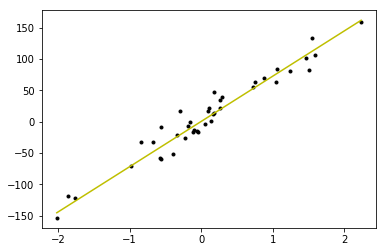

In [35]:
test_and_draw(model)

In [36]:
f = lambda x:0

In [37]:
f(2)

0

## 疑问
1 初始参数的选择？
2 梯度下降的实现过程：不太明白梯度怎么计算的。

### 5.4 Ridge线性回归

In [38]:
class RidgeLinearRegression(Regression):
    def __init__(self, alpha,n_iterations=1000,learning_rate=0.01):
        self.ragularization = l2_regularization(alpha=alpha)
        super(RidgeLinearRegression, self).__init__(n_iterations, learning_rate)
        
    def fit(self, X, y):
        super(RidgeLinearRegression, self).fit(X, y)
    
    def predict(self, X):
        return super(RidgeLinearRegression, self).predict(X)

In [39]:
ridge_model = RidgeLinearRegression(alpha=120, n_iterations=1000, learning_rate=0.01)

In [40]:
ridge_model.fit(X_train, y_train)

In [41]:
ridge_model.w

array([ 0.23588156, 72.14023411])

方差: 234.72513614690016


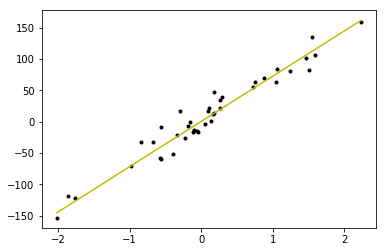

In [42]:
test_and_draw(ridge_model)

### 5.5 L1/L2调和的正则化
- 在调和的正则化中：
    - l1_ratio:在调和时，L1正则化的值所占的百分比[0,1]
    - l2_ratio=1 - l1_ratio（事实上算法中也找不到l2_ratio）
    - alpha: 全局整体的正则化权重
    - $ Loss = mse + \alpha * (l1\_ratio * L1Loss) + (1-l1\_ratio) * L2Loss) $

In [43]:
class l1_l2_regularization():
    """使用在ElasticNet中的正则化"""
    def __init__(self, alpha, l1_ratio=0.5):
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        
    def __call__(self, w):
        l1_loss = self.l1_ratio * np.linalg.norm(w, ord=1)
        l2_loss = (1- self.l1_ratio)*0.5*np.linalg.norm(w)**2
        return self.alpha*(l1_loss + l2_loss)
    
    def grad(self, w):
        l1_grad = self.l1_ratio*np.sign(w)
        l2_grad = (1-self.l1_ratio)*w
        return self.alpha*(l1_grad + l2_grad)

In [44]:
l1_l2 = l1_l2_regularization(alpha=0.1)

In [45]:
l1_l2(np.array([3, 4]))

0.9750000000000001

### 5.6 ElasticNet线性回归

In [46]:
class ElasticNetLinearRegression(Regression):
    def __init__(self, alpha, l1_ratio, n_iterations=2000, learning_rate=0.01):
        self.regularazition = l1_l2_regularization(alpha, l1_ratio=0.5)
        super(ElasticNetLinearRegression,self).__init__(n_iterations, learning_rate)
    
    def fit(self, X, y):
        super(ElasticNetLinearRegression,self).fit(X, y)
    
    def predict(self, X):
        return super(ElasticNetLinearRegression,self).predict(X)

In [47]:
elastic_model = ElasticNetLinearRegression(alpha=1.2, l1_ratio=0.5)

In [48]:
elastic_model.fit(X_train, y_train)

方差: 234.7367237413126


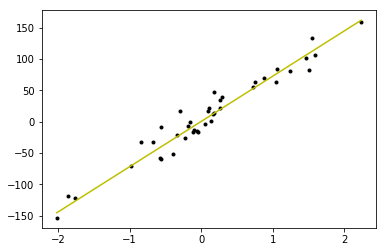

In [49]:
test_and_draw(elastic_model)

## 6 多项式回归
- 一阶多项式：$x_1,x_2,x_3$
- 二阶多项式：$x_1^2, x_2^2, x_3^2,x_1x_2,x_1x_3,x_2x_3$
- 三阶多项式：$x_1^3, x_2^3...$

### 6.1 构造多项式特征

In [50]:
from itertools import combinations_with_replacement

def polynomial_features(X, degree):
    n_samples, n_features = np.shape(X)
    
    # 对于每一行的feature构造排列组合，根据排列组合进行特征乘积，形成新的X`
    def index_combinations():
        combs = [combinations_with_replacement(range(n_features),i) for i in range(0, degree+1)]
        new_combs = [item for sub in combs for item in sub]
        return new_combs
    # print("Feature 列的排列组合：->", [x for x in index_combinations()])
    comb = index_combinations()
    feature_length = len(comb)
    output = np.empty((n_samples, feature_length))
    # print(output.shape)
    for i, index_combs in enumerate(comb):
        # print(i, index_combs)
        # 元素乘积
        output[:, i]= np.prod(X[:, index_combs], axis=1)
    return output

In [51]:
polynomial_features(np.array([[1,2], [4,5]]), degree=2)

array([[ 1.,  1.,  2.,  1.,  2.,  4.],
       [ 1.,  4.,  5., 16., 20., 25.]])

In [52]:
a = np.array([[1,2], [4,5]])
a

array([[1, 2],
       [4, 5]])

In [53]:
np.prod(a[:, (0,1)], axis=1)

array([ 2, 20])

In [85]:
class PolyRegression(Regression):
    """
    多项式回归就是将原来的feature转化成多阶的新feature，之后进行线性回归。
    ----------------
    degree：最大的阶数
    n_iterations:int
    learning_rate:float
    """
    def __init__(self, degree, n_iterations=3000, learning_rate=0.01):
        self.degree = degree
        self.regularization = lambda x:0
        self.regularization.grad = lambda x:0
        super(PolyRegression, self).__init__(n_iterations, learning_rate)
    
    def fit(self, X, y):
        X = polynomial_features(X, degree=self.degree)
        super(PolyRegression, self).fit(X, y)
    
    def predict(self, X):
        X = polynomial_features(X, degree=self.degree)
        return super(PolyRegression, self).predict(X)
       

In [86]:
poly_model = PolyRegression(degree=4)

In [87]:
poly_model.fit(X_train, y_train)

方差: 243.92632544029775


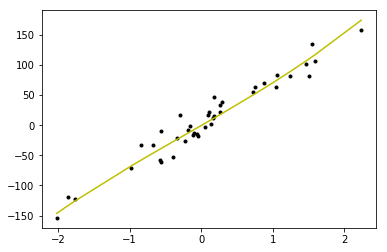

In [88]:
test_and_draw(poly_model)

## 7 数据的Normalize变换（归一化操作）
- 行归一化

In [89]:
def normalize(X, axis=-1, order=2):
    """将数据集的每一行进行列的归一化，--每一行的向量的L2范数归一"""
    L2 = np.linalg.norm(X, order, axis)
    L2[L2==0] = 1 # 为了过滤掉为0的L2距离，在归一化的时候会出现除零问题
    return X/np.expand_dims(L2, axis)

In [90]:
a = np.linalg.norm([[1,2], [3,4]], ord=2, axis=-1)
a

array([2.23606798, 5.        ])

In [91]:
np.expand_dims(a,axis=-1)

array([[2.23606798],
       [5.        ]])

In [92]:
normalize([[1,2], [3,4]], axis=-1, order=2)

array([[0.4472136 , 0.89442719],
       [0.6       , 0.8       ]])

## 8 多项式的Lasso回归